In [1]:
"""
Author: Bryan Bo Cao
Email: boca7588@colorado.edu or bo.cao-1@colorado.edu
Github Repo: https://github.com/BryanBo-Cao/neuralnets-deeplearning
Reference:
    https://github.com/tylersco/deep-neural-networks-art-images
    http://www.scipy-lectures.org/advanced/image_processing/
"""
from scipy import misc
import scipy
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os, sys
import glob
import pandas as pd
import csv
import math
from __future__ import division, print_function, absolute_import
from data.img.ArtDataLoader import ArtData
from Plotter import plot_acc_distance
from Plotter import plot_acc_cosine
from Plotter import plot_prob_distance_2lists
from Plotter import plot_prob_cosine_2lists
from Plotter import plot_prob_distance_4lists
from Plotter import plot_prob_cosine_4lists
from MySpearman import get_correlation_distance
from MySpearman import get_correlation_cosine
from scipy.stats import spearmanr

In [2]:
from scipy import misc
art_data = ArtData()
art_data.load_all_data()
#art_data.load_images()
#art_data.load_metadata()

ArtData Initialized!
2592  images loaded!


In [3]:
#print(art_data.train_images.keys())
#Validate
print(art_data.alpha_pairs['same'][0][95])
print(art_data.beta_pairs['same'][0][95])

print(art_data.alpha_pairs['diff'][0][95])
print(art_data.beta_pairs['diff'][0][95])

2018-impressionist-16x16.jpg
2134-impressionist-16x16.jpg
1233-cubist-16x16.jpg
1185-cubist-16x16.jpg


In [4]:
print(art_data.train_images['0001-cubist-16x16.jpg'].shape)

(16, 16, 3)


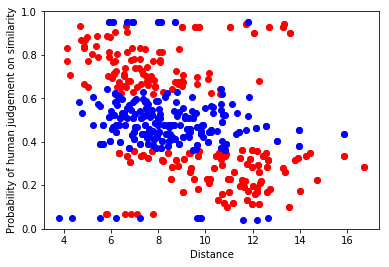

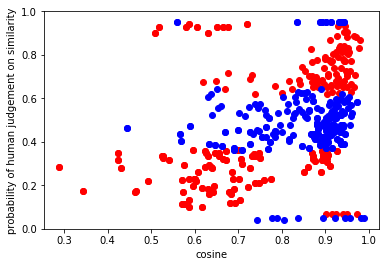

In [5]:
#Raw data
plot_acc_distance(art_data)
plot_acc_cosine(art_data)

In [6]:
get_correlation_distance(art_data)

SpearmanrResult(correlation=-0.4531196797090763, pvalue=1.6549967874513576e-30)

In [7]:
get_correlation_cosine(art_data)

SpearmanrResult(correlation=0.42701803307779929, pvalue=6.2551843304760119e-27)

In [8]:
#start of autoencoder
'''
Reference:
https://github.com/MorvanZhou/tutorials/edit/master/tensorflowTUT/tf21_autoencoder/full_code.py
My tutorial website: https://morvanzhou.github.io/tutorials/
'''
learning_rate = 0.01
training_epochs = 1000
batch_size = 256
display_step = 5
# Network Parameters
n_input = 768 # image data input (img shape: 16*16*3)

# tf Graph input (only pictures)
X = tf.placeholder("float", [None, n_input])

# hidden layer settings
n_hidden_1 = 384 # 1st layer num features
weights = {
    'encoder_h1': tf.Variable(tf.random_normal([n_input, n_hidden_1])),
    'decoder_h1': tf.Variable(tf.random_normal([n_hidden_1, n_input])),
}
biases = {
    'encoder_b1': tf.Variable(tf.random_normal([n_hidden_1])),
    'decoder_b1': tf.Variable(tf.random_normal([n_input])),
}

# Building the encoder
def encoder(x):
    # Encoder Hidden layer with sigmoid activation #1
    layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['encoder_h1']),
                                   biases['encoder_b1']))
    return layer_1


# Building the decoder
def decoder(x):
    # Encoder Hidden layer with sigmoid activation #1
    layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['decoder_h1']),
                                   biases['decoder_b1']))
    return layer_1

In [9]:
# Construct model
encoder_op = encoder(X)
decoder_op = decoder(encoder_op)

# Prediction
y_pred = decoder_op
y_bottleneck = encoder_op

# Targets (Labels) are the input data.
y_true = X

# Define loss and optimizer, minimize the squared error
cost = tf.reduce_mean(tf.pow(y_true - y_pred, 2))
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)


# Launch the graph
with tf.Session() as sess:
    # tf.initialize_all_variables() no long valid from
    # 2017-03-02 if using tensorflow >= 0.12
    if int((tf.__version__).split('.')[1]) < 12 and int((tf.__version__).split('.')[0]) < 1:
        init = tf.initialize_all_variables()
    else:
        init = tf.global_variables_initializer()
    sess.run(init)
    total_batch = int(len(art_data.train_images) / batch_size)
    # Training cycle
    for epoch in range(training_epochs):
        # Loop over all batches
        for i in range(total_batch):
            batch_xs, batch_ys = art_data.next_batch(batch_size)  # max(x) = 1, min(x) = 0
            # Run optimization op (backprop) and cost op (to get loss value)
            _, c = sess.run([optimizer, cost], feed_dict={X: batch_xs})
        # Display logs per epoch step
        if epoch % display_step == 0:
            print("Epoch:", '%04d' % (epoch+1),
                  "cost=", "{:.9f}".format(c))

    print("Optimization Finished!")
    
    #alpha
    encode_output_alpha_a = sess.run(
        y_bottleneck, feed_dict={X: art_data.alpha_set_flatten[0]})
    encode_output_alpha_b = sess.run(
        y_bottleneck, feed_dict={X: art_data.alpha_set_flatten[1]})
    
    encode_decode_output_alpha_a = sess.run(
        y_pred, feed_dict={X: art_data.alpha_set_flatten[0]})
    encode_decode_output_alpha_b = sess.run(
        y_pred, feed_dict={X: art_data.alpha_set_flatten[1]})
    
    #beta
    encode_output_beta_a = sess.run(
        y_bottleneck, feed_dict={X: art_data.beta_set_flatten[0]})
    encode_output_beta_b = sess.run(
        y_bottleneck, feed_dict={X: art_data.beta_set_flatten[1]})
    
    encode_decode_output_beta_a = sess.run(
        y_pred, feed_dict={X: art_data.beta_set_flatten[0]})
    encode_decode_output_beta_b = sess.run(
        y_pred, feed_dict={X: art_data.beta_set_flatten[1]})
  
encode_outout_alpha_a = encode_output_alpha_a.tolist()
encode_output_alpha_b = encode_output_alpha_b.tolist()

encode_decode_output_alpha_a = encode_decode_output_alpha_a.tolist()
encode_decode_output_alpha_b = encode_decode_output_alpha_b.tolist()

encode_output_beta_a = encode_output_beta_a.tolist()
encode_output_beta_b = encode_output_beta_b.tolist()

encode_decode_output_beta_a = encode_decode_output_beta_a.tolist()
encode_decode_output_beta_b = encode_decode_output_beta_b.tolist()

Epoch: 0001 cost= 0.221936300
Epoch: 0006 cost= 0.106893241
Epoch: 0011 cost= 0.098713733
Epoch: 0016 cost= 0.105805419
Epoch: 0021 cost= 0.101254754
Epoch: 0026 cost= 0.096862383
Epoch: 0031 cost= 0.100315057
Epoch: 0036 cost= 0.096704207
Epoch: 0041 cost= 0.097527318
Epoch: 0046 cost= 0.092360832
Epoch: 0051 cost= 0.091107048
Epoch: 0056 cost= 0.089459956
Epoch: 0061 cost= 0.089836441
Epoch: 0066 cost= 0.079662353
Epoch: 0071 cost= 0.089196675
Epoch: 0076 cost= 0.087689184
Epoch: 0081 cost= 0.086502634
Epoch: 0086 cost= 0.087606616
Epoch: 0091 cost= 0.087049402
Epoch: 0096 cost= 0.086026214
Epoch: 0101 cost= 0.082099736
Epoch: 0106 cost= 0.081567675
Epoch: 0111 cost= 0.082433820
Epoch: 0116 cost= 0.083539568
Epoch: 0121 cost= 0.074273050
Epoch: 0126 cost= 0.083304875
Epoch: 0131 cost= 0.083702348
Epoch: 0136 cost= 0.081194319
Epoch: 0141 cost= 0.082824059
Epoch: 0146 cost= 0.082087107
Epoch: 0151 cost= 0.082918234
Epoch: 0156 cost= 0.079665624
Epoch: 0161 cost= 0.080088519
Epoch: 016

In [10]:
#alpha

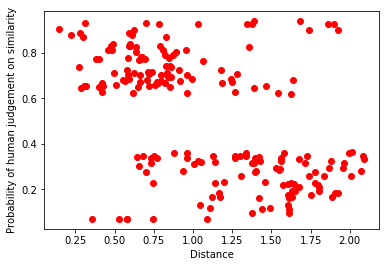

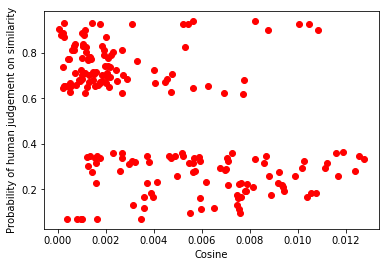

In [11]:
#alpha, bottleneck output, distance, cosine, prob_human_similarity
encode_output_alpha_distance = art_data.get_distance_list_flatten(encode_output_alpha_a, encode_output_alpha_b)
encode_output_alpha_cosine = art_data.get_cosine_list_flatten(encode_output_alpha_a, encode_output_alpha_b)
plot_prob_distance_2lists(encode_output_alpha_distance, art_data.alpha_prob_human_similarity)
plot_prob_cosine_2lists(encode_output_alpha_cosine, art_data.alpha_prob_human_similarity)

In [12]:
#alpha, bottleneck output, distance, prob_human_similarity
spearmanr(encode_output_alpha_distance, art_data.alpha_prob_human_similarity, axis=None)

SpearmanrResult(correlation=-0.46920119271269561, pvalue=6.6683929681443361e-12)

In [13]:
#alpha, bottleneck output, cosine, prob_human_similarity
spearmanr(encode_output_alpha_cosine, art_data.alpha_prob_human_similarity, axis=None)

SpearmanrResult(correlation=-0.46895023583207968, pvalue=6.8658966178619743e-12)

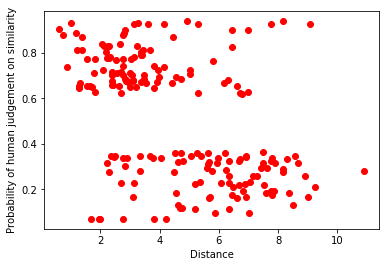

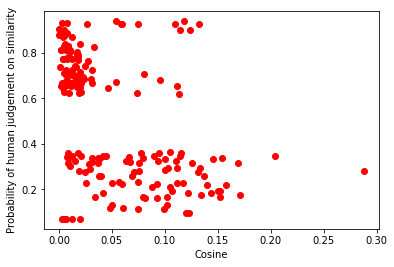

In [14]:
#alpha, network output, distance, cosine, prob_human_similarity
encode_decode_output_alpha_distance = art_data.get_distance_list_flatten(
                    encode_decode_output_alpha_a, encode_decode_output_alpha_b)
encode_decode_output_alpha_cosine = art_data.get_cosine_list_flatten(
                    encode_decode_output_alpha_a, encode_decode_output_alpha_b)
plot_prob_distance_2lists(encode_decode_output_alpha_distance, art_data.alpha_prob_human_similarity)
plot_prob_cosine_2lists(encode_decode_output_alpha_cosine, art_data.alpha_prob_human_similarity)

In [15]:
#alpha, network output, distance, prob_human_similarity
spearmanr(encode_decode_output_alpha_distance, art_data.alpha_prob_human_similarity, axis=None)

SpearmanrResult(correlation=-0.45627945684287219, pvalue=2.9072845659789184e-11)

In [16]:
#alpha, network output, cosine, prob_human_similarity
spearmanr(encode_decode_output_alpha_cosine, art_data.alpha_prob_human_similarity, axis=None)

SpearmanrResult(correlation=-0.49172542057527674, pvalue=4.39778101960554e-13)

In [17]:
#beta

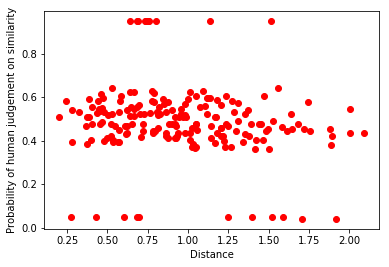

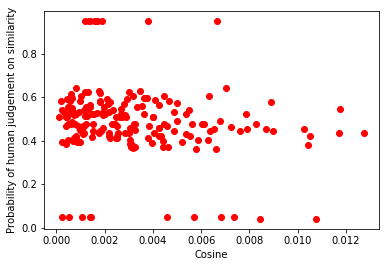

In [18]:
#beta, bottleneck output, distance, cosine, prob_human_similarity
encode_output_beta_distance = art_data.get_distance_list_flatten(encode_output_beta_a, encode_output_beta_b)
encode_output_beta_cosine = art_data.get_cosine_list_flatten(encode_output_beta_a, encode_output_beta_b)
plot_prob_distance_2lists(encode_output_beta_distance, art_data.beta_prob_human_similarity)
plot_prob_cosine_2lists(encode_output_beta_cosine, art_data.beta_prob_human_similarity)

In [19]:
#beta, bottleneck output, distance, prob_human_similarity
spearmanr(encode_output_beta_distance, art_data.beta_prob_human_similarity, axis=None)

SpearmanrResult(correlation=-0.19398070761444883, pvalue=0.0070181787794901399)

In [20]:
#beta, bottleneck output, cosine, prob_human_similarity
spearmanr(encode_output_beta_cosine, art_data.beta_prob_human_similarity, axis=None)

SpearmanrResult(correlation=-0.19423254691819805, pvalue=0.0069433591611054108)

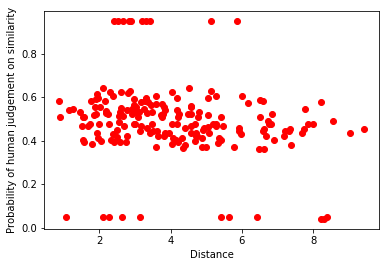

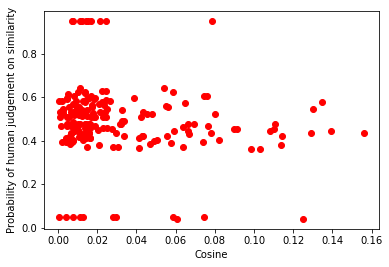

In [21]:
#beta, network output, distance, cosine, prob_human_similarity
encode_decode_output_beta_distance = art_data.get_distance_list_flatten(
                    encode_decode_output_beta_a, encode_decode_output_beta_b)
encode_decode_output_beta_cosine = art_data.get_cosine_list_flatten(
                    encode_decode_output_beta_a, encode_decode_output_beta_b)
plot_prob_distance_2lists(encode_decode_output_beta_distance, art_data.beta_prob_human_similarity)
plot_prob_cosine_2lists(encode_decode_output_beta_cosine, art_data.beta_prob_human_similarity)

In [22]:
#beta, network output, distance, prob_human_similarity
spearmanr(encode_decode_output_beta_distance, art_data.beta_prob_human_similarity, axis=None)

SpearmanrResult(correlation=-0.23907690186123043, pvalue=0.00083875352101389666)

In [23]:
#beta, network output, cosine, prob_human_similarity
spearmanr(encode_decode_output_beta_cosine, art_data.beta_prob_human_similarity, axis=None)

SpearmanrResult(correlation=-0.13671652007204055, pvalue=0.058635325075581439)

In [24]:
#alpha & beta

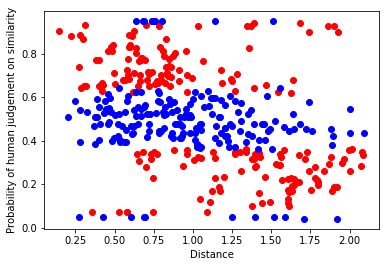

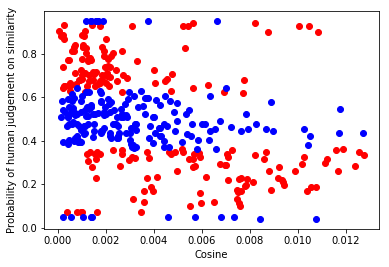

In [25]:
#alpha & beta bottleneck output, distance, cosine, prob_human_similarity
encode_output_distance = []
encode_output_distance.extend(encode_output_alpha_distance)
encode_output_distance.extend(encode_output_beta_distance)

encode_output_cosine = []
encode_output_cosine.extend(encode_output_alpha_cosine)
encode_output_cosine.extend(encode_output_beta_cosine)

prob_human_similarity = []
prob_human_similarity.extend(art_data.alpha_prob_human_similarity)
prob_human_similarity.extend(art_data.beta_prob_human_similarity)

plot_prob_distance_4lists(encode_output_alpha_distance, art_data.alpha_prob_human_similarity,
                            encode_output_beta_distance, art_data.beta_prob_human_similarity)
plot_prob_cosine_4lists(encode_output_alpha_cosine, art_data.alpha_prob_human_similarity,
                           encode_output_beta_cosine, art_data.beta_prob_human_similarity)

In [26]:
#alpha & beta, bottlenect output, distance, prob_human_similarity
spearmanr(encode_output_distance, prob_human_similarity, axis=None)

SpearmanrResult(correlation=-0.40924332719113371, pvalue=6.1455950349034607e-17)

In [27]:
#alpha & beta, bottlenect output, cosine, prob_human_similarity
spearmanr(encode_output_cosine, prob_human_similarity, axis=None)

SpearmanrResult(correlation=-0.40877271721292718, pvalue=6.7204330532836872e-17)